In [1]:
!pip install kaggle 

  Running setup.py bdist_wheel for kaggle: started
  Running setup.py bdist_wheel for kaggle: finished with status 'done'
  Stored in directory: C:\Users\116952\AppData\Local\pip\Cache\wheels\a4\29\3e\1065ec22dad7255300b56c56611abeb064300be05ae4bce5ed
Successfully built kaggle


In [8]:
!kaggle config set -n competition -v talkingdata-adtracking-fraud-detection

competition is now set to: talkingdata-adtracking-fraud-detection


this scrip 

train on day8,day9  validate on day9 with/wo ip<126420


- fine tune parameters(65)


1. train: day8 ,day9 (5mil)val: day9 ip<126420
    
    
    

In [1]:
import pandas as pd 
import gc
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
import time

In [2]:
with pd.HDFStore('../input/feat/feat66_trn_day8_val_day9.h5') as store:
    print(store.keys())
    train_df = store['train_df']
    val_df = store['valid_df']
    test_df = store['test_df']

['/test_df', '/train_df', '/valid_df']


In [3]:
print('shape of train:{}'.format(train_df.shape))
print('shape of val  :{}'.format(val_df.shape))
print('shape of test :{}'.format(test_df.shape))

shape of train:(62360949, 31)
shape of val  :(62832642, 31)
shape of test :(18790469, 31)


In [4]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.2,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")
    dtrain_np = dtrain[predictors].values.astype(np.float32)
    dtrain_label = dtrain[target].values.astype(np.float32)
    del dtrain;gc.collect()
    
    dvalid_np = dvalid[predictors].values.astype(np.float32)
    dvalid_label = dvalid[target].values.astype(np.float32)
    del dvalid; gc.collect()
    
    print("lgb dataset...")
    xgtrain = lgb.Dataset(dtrain_np, label=dtrain_label,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid_np, label=dvalid_label,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}
    print('start training...')
    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgvalid], 
                     valid_names=['valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return (bst1,bst1.best_iteration)

In [5]:
train_df = train_df.append(val_df.head(50000000))
val_df = val_df.iloc[50000000:]
val_df = val_df[val_df.ip< 126420]
gc.collect()

26

In [6]:
print('shape of train:{}'.format(train_df.shape))
print('shape of val  :{}'.format(val_df.shape))
print('shape of test :{}'.format(test_df.shape))

shape of train:(112360949, 31)
shape of val  :(10647592, 31)
shape of test :(18790469, 31)


In [7]:
train_df.columns

Index(['app', 'app_cumcnt_ip_device_os', 'app_mean_target', 'app_nunique_ip',
       'app_nunique_ip_device_os', 'channel', 'channel_cnt_ip_app',
       'channel_cnt_ip_day_hour', 'channel_mean_target', 'channel_nunique_ip',
       'click_id', 'click_time', 'day', 'device', 'hour', 'hour_mean_target',
       'ip', 'ip_mean_target', 'is_attributed', 'next_click_dt', 'os',
       'device_cnt_ip_app_os_channel_day_hour', 'channel_cnt_ip_app_os',
       'hour_nunique_ip_day', 'os_nunique_ip_app', 'device_nunique_ip',
       'shift_iptcnt', 'next_click_dt_ia', 'next_click_iodac',
       'channel_cnt_ip_device', 'device_cnt_app_channel'],
      dtype='object')

In [8]:
target = 'is_attributed'
categorical = ['app', 'device', 'os', 'channel', 'hour']#,'day']

predictors = list(val_df.columns)
remove_col = ['click_id','click_time','is_attributed','day']
predictors = [e for e in predictors if e not in remove_col]

print('numbers of features', len(predictors))
predictors

numbers of features 27


['app',
 'app_cumcnt_ip_device_os',
 'app_mean_target',
 'app_nunique_ip',
 'app_nunique_ip_device_os',
 'channel',
 'channel_cnt_ip_app',
 'channel_cnt_ip_day_hour',
 'channel_mean_target',
 'channel_nunique_ip',
 'device',
 'hour',
 'hour_mean_target',
 'ip',
 'ip_mean_target',
 'next_click_dt',
 'os',
 'device_cnt_ip_app_os_channel_day_hour',
 'channel_cnt_ip_app_os',
 'hour_nunique_ip_day',
 'os_nunique_ip_app',
 'device_nunique_ip',
 'shift_iptcnt',
 'next_click_dt_ia',
 'next_click_iodac',
 'channel_cnt_ip_device',
 'device_cnt_app_channel']

In [9]:
params = {
    'two_round' :True,
    'learning_rate': 0.2,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1    
    'max_depth': 3,  # -1 means no limit
#     'max_depth' : 4,
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
#     'colsample_bytree': 0.7,
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight': 200 # because training data is extremely unbalanced 
#     'scale_pos_weight': 99.7
    
}

In [10]:
# print("Training...")
start_time = time.time()
(bst,best_iteration) = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary',  
                        metrics='auc',
                        early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=1000,  
                        categorical_features=categorical
                        )
end_time = time.time()
print('training time :{:.2f} sec'.format(end_time-start_time))

preparing validation datasets
lgb dataset...
start training...


C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	valid's auc: 0.936549
[20]	valid's auc: 0.947214
[30]	valid's auc: 0.95558
[40]	valid's auc: 0.959897
[50]	valid's auc: 0.962437
[60]	valid's auc: 0.964024
[70]	valid's auc: 0.965205
[80]	valid's auc: 0.9653
[90]	valid's auc: 0.965649
[100]	valid's auc: 0.965942
[110]	valid's auc: 0.966396
[120]	valid's auc: 0.966186
[130]	valid's auc: 0.966666
[140]	valid's auc: 0.967003
[150]	valid's auc: 0.967412
[160]	valid's auc: 0.967462
[170]	valid's auc: 0.967664
[180]	valid's auc: 0.967704
[190]	valid's auc: 0.967754
[200]	valid's auc: 0.968069
[210]	valid's auc: 0.968138
[220]	valid's auc: 0.968067
[230]	valid's auc: 0.968154
[240]	valid's auc: 0.968366
[250]	valid's auc: 0.968382
[260]	valid's auc: 0.968091
[270]	valid's auc: 0.968178
[280]	valid's auc: 0.968294
Early stopping, best iteration is:
[251]	valid's auc: 0.968392

Model Report
bst1.best_iteration:  251
auc: 0.968392393514
training time :2030.89 sec


____

# Sub 
 

Plot feature importances...


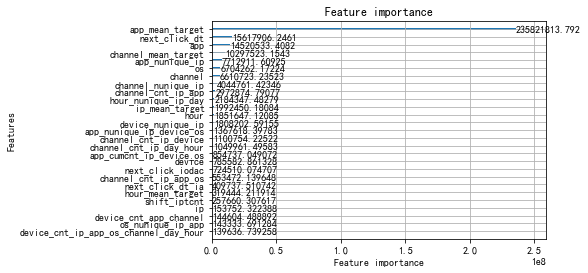

In [11]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=100,importance_type='gain')

In [12]:
feat_imp = pd.DataFrame({'f':bst.feature_name(),
                         'split':bst.feature_importance(importance_type='split'),
                         'gain':bst.feature_importance(importance_type='gain')}).sort_values(by='split',ascending=False)
feat_imp.to_csv('../find/feat_impact07_1.csv',index=False)

In [32]:
# !kaggle competitions submit -c talkingdata-adtracking-fraud-detection -f sub_it9 -m "test"

Traceback (most recent call last):
  File "c:\program files\anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\program files\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Program Files\Anaconda3\Scripts\kaggle.exe\__main__.py", line 9, in <module>
  File "c:\program files\anaconda3\lib\site-packages\kaggle\cli.py", line 37, in main
    out = args.func(**command_args)
  File "c:\program files\anaconda3\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 195, in competition_submit
    content_length=os.path.getsize(file),
  File "c:\program files\anaconda3\lib\genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [WinError 2] 系統找不到指定的檔案。: 'sub_it9'


In [13]:
bst.save_model('../output/model/lgb_val_9683_on_day9.txt')

In [14]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype(int)

print("Predicting...")
sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)
print('complete')    

Predicting...
complete


In [15]:
sub.head()

,click_id,is_attributed
125193591,0,0.251312
125193592,1,0.026729
125193593,2,0.005700
125193594,3,0.065307
125193595,4,0.030950


In [16]:
sub['click_id'] = sub.click_id.astype('uint32')
sub['is_attributed'] = sub.is_attributed.astype('float16')

In [17]:
print('writing...')
fileno = 14
sub.to_csv('../output/sub_it{}.csv.gz'.format(fileno),index=False,compression='gzip')
print('finished')

writing...
finished


_____